Imports

In [39]:
import os
import csv
import spacy
import collections
import numpy as np
import pandas as pd
import matplotlib

In [40]:


csv_folder = "./CSVS/"
csv_files = os.listdir(csv_folder)

sentences_df = pd.DataFrame(columns=["TITLE", "SENTENCE", "WORD_COUNT"])


for file in csv_files:
    path = os.path.join(csv_folder, file)
    title = file.replace(".csv", "") 

    df = pd.read_csv(path)

    # Check if the "SENTENCES" column exists in the DataFrame
    if "SENTENCES" in df.columns:
        # Create a new DataFrame with titles and sentences
        temp_df = df[["SENTENCES"]].rename(columns={"SENTENCES": "SENTENCE"})
        temp_df["TITLE"] = title  # Add the title column

        # Append to the main sentences_df DataFrame
        sentences_df = pd.concat([sentences_df, temp_df], ignore_index=True)

print(sentences_df["SENTENCE"].head())




0    masking significant epistemological distinctio...
1    For in - stance, when we use the term “cogniti...
2    Similarly, when an ap - proach to learning and...
3    All of the aforementioned theories and their i...
4    Further, such epistemological differences make...
Name: SENTENCE, dtype: object


<Axes: >

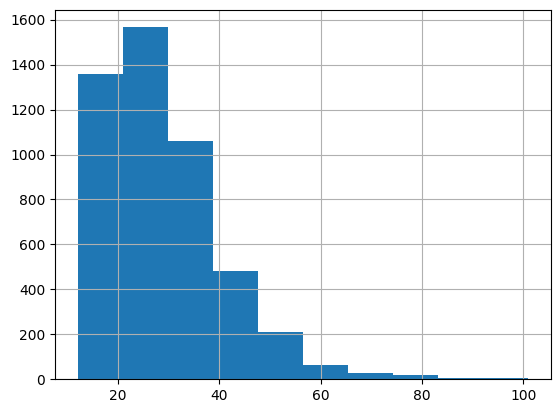

In [41]:
# Add other features 

sentences_df["TITLE"] = sentences_df["TITLE"].astype("string")
sentences_df["SENTENCE"] = sentences_df["SENTENCE"].astype("string")
sentences_df["WORD_COUNT"] = sentences_df["SENTENCE"].apply(lambda x: len(x.split(" ")))
sentences_df["WORD_COUNT"].hist()



Use Spacy to Extract Features

In [42]:

nlp = spacy.load("en_core_web_sm")

In [43]:


sentences = sentences_df["SENTENCE"]
random_sentence = np.random.choice(sentences)


def getExtractedSentenceInfo(s: str):
    doc = nlp(s)
    is_stop_count = 0
    pos_tag_count = collections.defaultdict(int)
    structured_pos = []  # Store the POS tags in a structured way
    deps = collections.defaultdict(set)

    # Iterate over each token in the document
    for token in doc:
        if token.is_stop:
            is_stop_count += 1
        pos_tag_count[token.pos_] += 1
        structured_pos.append((token.pos_))
        dep = token.dep_
        deps[dep].add(token.text)

    # Return both stop word count and POS tag dict
    return is_stop_count, dict(pos_tag_count), structured_pos, dict(deps)


print(random_sentence, getExtractedSentenceInfo(random_sentence))

# Apply the function to the dataframe, storing both stop word counts and POS tags
sentences_df["IS_STOP_COUNT"], sentences_df["POS_TAGS"], sentences_df["STRUCTURED_POS"], sentences_df["DEPS"] = zip(
    *sentences_df["SENTENCE"].apply(getExtractedSentenceInfo))

# (1) Length (3 categorical variables) - Short, Medium, Long
# (2) Stop Word [Complexity] - Low Count, High Count
# (3) POS TAG RULES - Low Complexity (No SCONJs), Medium Complexity (1 SCONJ), High Complexity (2+ SCONJs)


def getLengthCategory(word_count: int):
    if word_count < 10:
        return "Short"
    elif word_count < 20:
        return "Medium"
    else:
        return "Long"


def getStopCategory(stop_count: int, word_count: int):
    # if fewer than 15% of the words are stop words, low, else high
    # calculate the percentage of stop words
    stop_percentage = stop_count / word_count

    if stop_percentage < 0.15:
        return "Low"
    else:
        return "High"


def getPosCategory(pos_tags: dict):
    # if there are more than 2 SCONJ tags, high, else medium, else low
    if pos_tags.get("SCONJ", 0) >= 2:
        return "High"
    elif pos_tags.get("SCONJ", 0) == 1:
        return "Medium"
    else:
        return "Low"


sentences_df["LENGTH_CATEGORY"] = sentences_df["WORD_COUNT"].apply(
    getLengthCategory)
sentences_df["STOP_CATEGORY"] = sentences_df.apply(
    lambda x: getStopCategory(x["IS_STOP_COUNT"], x["WORD_COUNT"]), axis=1)
sentences_df["POS_CATEGORY"] = sentences_df["POS_TAGS"].apply(getPosCategory)


The current investigation represents an initial endeavor to apply the relational reasoning framework to the vocabulary knowledge domain (6, {'DET': 4, 'ADJ': 4, 'NOUN': 6, 'VERB': 2, 'PART': 1, 'ADP': 1}, ['DET', 'ADJ', 'NOUN', 'VERB', 'DET', 'ADJ', 'NOUN', 'PART', 'VERB', 'DET', 'ADJ', 'NOUN', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN'], {'det': {'an', 'The', 'the'}, 'amod': {'vocabulary', 'initial', 'relational', 'current'}, 'nsubj': {'investigation'}, 'ROOT': {'represents'}, 'dobj': {'framework', 'endeavor'}, 'aux': {'to'}, 'relcl': {'apply'}, 'compound': {'knowledge', 'reasoning'}, 'prep': {'to'}, 'pobj': {'domain'}})


In [44]:
len(sentences_df)

4801

Classifications for training

In [45]:
# (1) Length (3 categorical variables) - Short, Medium, Long
# (2) Stop Word [Complexity] - Low Count, High Count
# (3) POS TAG RULES - Low Complexity (No SCONJs), Medium Complexity (1 SCONJ), High Complexity (2+ SCONJs)

def getLengthCategory(word_count: int):
    if word_count < 10:
        return "Short"
    elif word_count < 20:
        return "Medium"
    else:
        return "Long"
    
def getStopCategory(stop_count: int , word_count: int):
    # if fewer than 15% of the words are stop words, low, else high
    # calculate the percentage of stop words
    stop_percentage = stop_count / word_count

    if stop_percentage < 0.15:
        return "Low"
    else:
        return "High"
    
def getPosCategory(pos_tags: dict):
    # if there are more than 2 SCONJ tags, high, else medium
    if pos_tags.get("SCONJ", 0) >= 2:
        return "High"
    elif pos_tags.get("SCONJ", 0) == 1:
        return "Medium"
    else:
        return "Low"
    
    
# loop through the dataframe and apply the functions
sentences_df["LENGTH_CATEGORY"] =sentences_df["WORD_COUNT"].apply(getLengthCategory)
sentences_df["STOP_CATEGORY"] = sentences_df.apply(lambda x: getStopCategory(x["IS_STOP_COUNT"], x["WORD_COUNT"]), axis=1)
sentences_df["POS_CATEGORY"] = sentences_df["POS_TAGS"].apply(getPosCategory)

SENDING TO CSV (AND HTML FOR DISPLAY)

In [46]:
path="EXTRACTED_SENTENCE_DATA"
sentences_df.to_csv(f'{path}.csv')
sentences_df.to_html(f'{path}.html')


MAKING SURE I SENT IT CORRECTLY

In [47]:
df_test = pd.read_csv(f'{path}.csv')